# Main Quest 2: Image Segmentation

## 이미지 데이터 전처리

In [1]:
import os

image_dir = "./images/images"

input_img_paths = sorted([os.path.join(image_dir, fname) 
                          for fname in os.listdir(image_dir) 
                          if not (('fuse' in fname) or ('save' in fname))])
target_img_paths = sorted([os.path.join(image_dir, fname) 
                           for fname in os.listdir(image_dir) 
                           if 'fuse' in fname])

In [2]:
# 입력 데이터 개수 확인
len(input_img_paths)


200

In [3]:
# 타겟 데이터 개수 확인
len(target_img_paths)

200

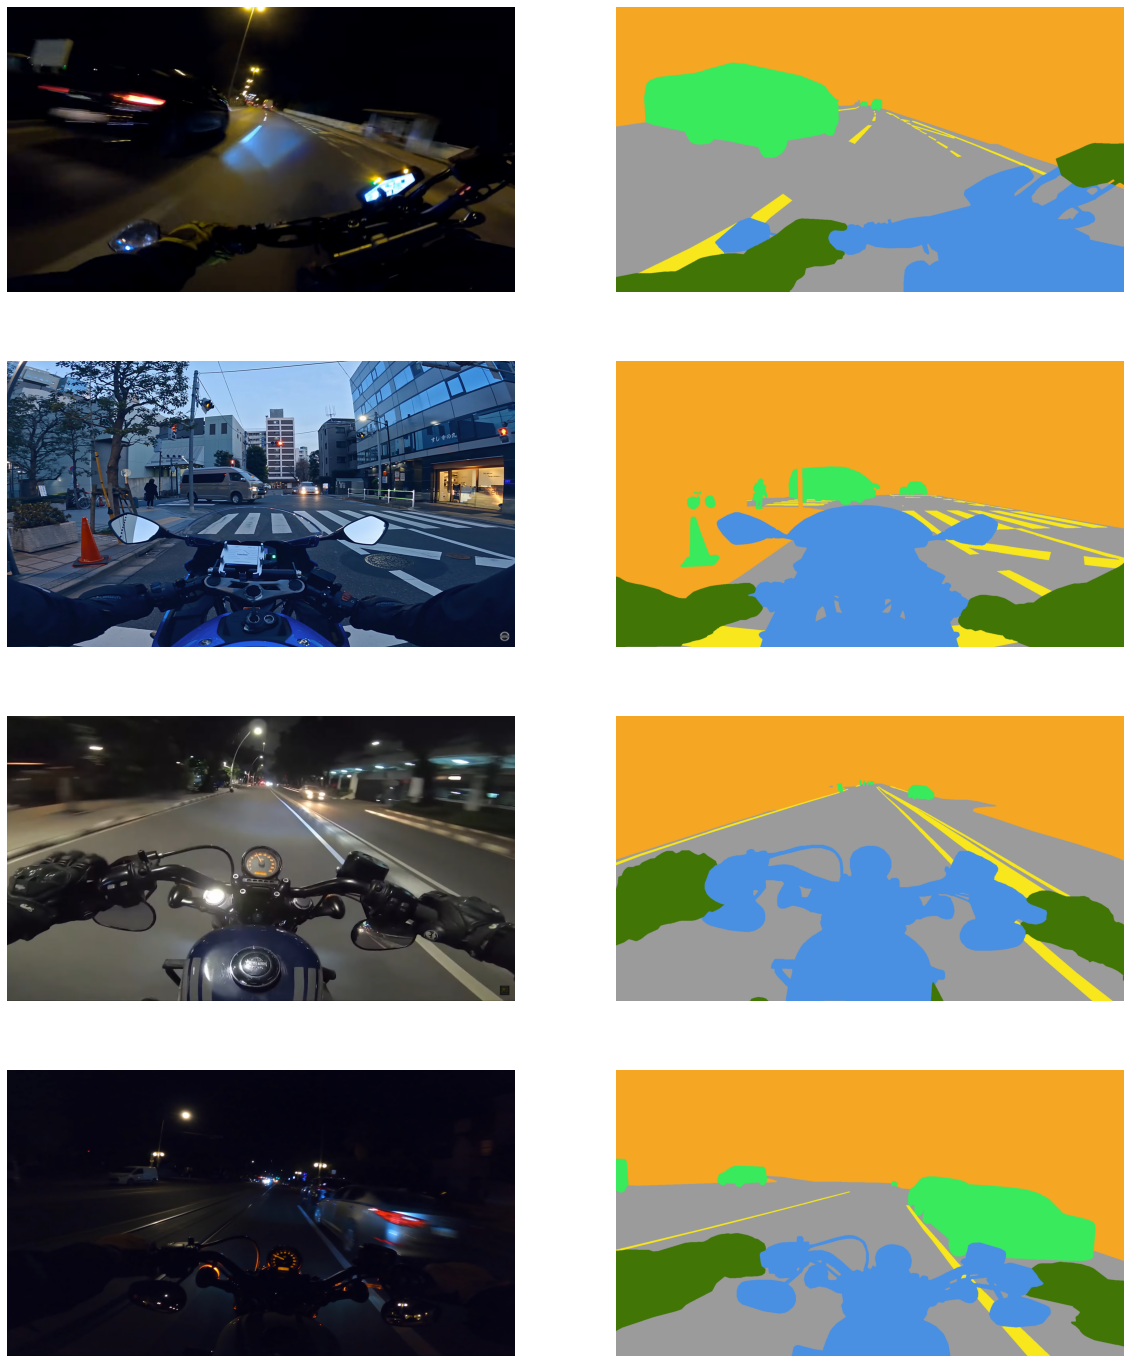

In [4]:
# 데이터 직접 확인
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.figure(figsize=(20,25))
for j in range(4):
    plt.subplot(4,2,2*j+1)
    plt.axis("off")
    plt.imshow(load_img(input_img_paths[j*50]))
    plt.subplot(4,2,2*j+2)
    plt.axis("off")
    plt.imshow(load_img(target_img_paths[j*50]))

In [5]:
# 타겟 데이터의 내부 값 확인
import numpy as np

target = load_img(target_img_paths[0], color_mode='grayscale')
target = img_to_array(target)
target = target.astype("uint8")
color = np.unique(target)
color

array([ 89, 132, 155, 165, 175, 213], dtype=uint8)

6개의 영역이 서로 다른 정수로 표현되어있다. 이를 0~5의 정수로 바꿔준다.

In [6]:
dict_color_to_label = dict()
dict_label_to_color = dict()
for i in range(6):
    i = np.uint8(i)
    dict_color_to_label[color[i]] = i
    dict_label_to_color[i] = color[i]

In [7]:
type(dict_color_to_label[89])

numpy.uint8

In [8]:
# 이미지 크기 확인
img = load_img(input_img_paths[0])
img.size

(1920, 1080)

In [9]:
import random

img_size = (272, 480) # 리스케일링 비율은 원본과 최대한 가깝게 유지하되, UNet 모델에서 MaxPooling을 4번 적용 가능한 정수 비율을 적용
num_imgs = len(input_img_paths)

# 데이터 셔플 및 전처리
random.Random(100).shuffle(input_img_paths)
random.Random(100).shuffle(target_img_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8")
    for val in color:
        img = np.where(img==val, dict_color_to_label[val], img)
    return img
        
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_img_paths[i])


In [10]:
targets[0].shape

(272, 480, 1)

In [11]:
input_imgs[0].shape

(272, 480, 3)

In [12]:
# 학습, 검증, 테스트 데이터 분할

num_test_samples = 20
num_val_samples = 20
train_input_imgs = input_imgs[:-(num_test_samples + num_val_samples)]
train_targets = targets[:-(num_test_samples + num_val_samples)]
val_input_imgs = input_imgs[-(num_test_samples + num_val_samples):-num_test_samples]
val_targets = targets[-(num_test_samples + num_val_samples):-num_test_samples]
test_input_imgs = input_imgs[-num_test_samples:]
test_targets = targets[-num_test_samples:]

## 모델 정의 및 학습

In [13]:
# 모델 정의

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def get_model(img_size, num_classes):

    inputs = Input(shape=img_size + (3,))
    rs = Rescaling(1./255)(inputs)
    
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(rs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = get_model(img_size=img_size, num_classes=6)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 272, 480, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 272, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 272, 480, 64) 1792        rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 272, 480, 64) 36928       conv2d[0][0]                     
______________________________________________________________________________________________

In [14]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [TensorBoard(log_dir='./log'), ModelCheckpoint("segmentation.h5", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, 
                    epochs=100, 
                    callbacks=callbacks, 
                    batch_size=16, 
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/100
10/10 [==============================] - 63s 3s/step - loss: 15.4652 - accuracy: 0.2942 - val_loss: 1.7267 - val_accuracy: 0.2378
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 1.6483 - accuracy: 0.3488 - val_loss: 1.5133 - val_accuracy: 0.4455
Epoch 3/100
10/10 [==============================] - 17s 2s/step - loss: 1.4741 - accuracy: 0.3984 - val_loss: 1.4543 - val_accuracy: 0.4344
Epoch 4/100
10/10 [==============================] - 17s 2s/step - loss: 1.4240 - accuracy: 0.4220 - val_loss: 1.4196 - val_accuracy: 0.4455
Epoch 5/100
10/10 [==============================] - 17s 2s/step - loss: 1.4055 - accuracy: 0.4233 - val_loss: 1.4053 - val_accuracy: 0.4454
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 1.3711 - accuracy: 0.4233 - val_loss: 1.3621 - val_accuracy: 0.4451
Epoch 7/100
10/10 [==============================] - 17s 2s/step - loss: 1.3126 - accuracy: 0.4472 - val_loss: 1.2712 - val_accuracy: 0.5015
Epoch 8/100


Epoch 59/100
10/10 [==============================] - 17s 2s/step - loss: 0.4067 - accuracy: 0.8565 - val_loss: 0.4667 - val_accuracy: 0.8363
Epoch 60/100
10/10 [==============================] - 17s 2s/step - loss: 0.3572 - accuracy: 0.8727 - val_loss: 0.4318 - val_accuracy: 0.8488
Epoch 61/100
10/10 [==============================] - 17s 2s/step - loss: 0.3144 - accuracy: 0.8867 - val_loss: 0.4266 - val_accuracy: 0.8460
Epoch 62/100
10/10 [==============================] - 17s 2s/step - loss: 0.2830 - accuracy: 0.8969 - val_loss: 0.3989 - val_accuracy: 0.8580
Epoch 63/100
10/10 [==============================] - 17s 2s/step - loss: 0.2576 - accuracy: 0.9064 - val_loss: 0.3985 - val_accuracy: 0.8659
Epoch 64/100
10/10 [==============================] - 17s 2s/step - loss: 0.2433 - accuracy: 0.9120 - val_loss: 0.3976 - val_accuracy: 0.8684
Epoch 65/100
10/10 [==============================] - 17s 2s/step - loss: 0.2342 - accuracy: 0.9153 - val_loss: 0.4056 - val_accuracy: 0.8612
Epoch 

## 학습 결과 평가

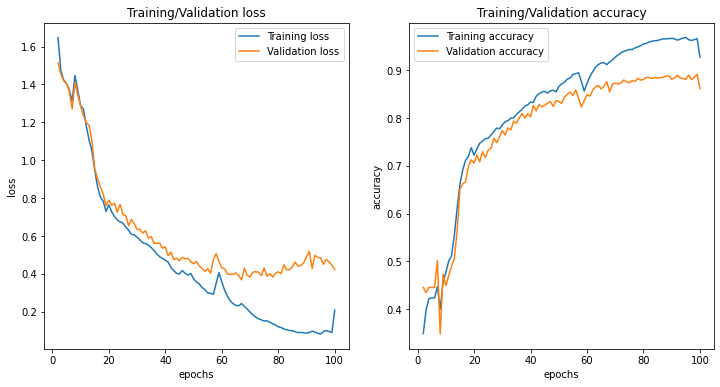

In [15]:
# 결과 시각화

epochs = range(1, len(history.history["loss"]) + 1)[1:]
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
acc = history.history["accuracy"][1:]
val_acc = history.history["val_accuracy"][1:]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy")
plt.legend()

80 에포크 이후로 과적합이 발생하기 시작하는 것으로 보인다.

In [16]:
from tensorflow.keras.models import load_model

model_path = 'segmentation.h5'

loaded_model = load_model(model_path)
loaded_model.evaluate(test_input_imgs, test_targets)


1/1 [==============================] - 24s 24s/step - loss: 0.3220 - accuracy: 0.8967


[0.32200542092323303, 0.896656334400177]

테스트 데이터에서 약 90%의 정확도를 보였다.

In [17]:
prediction = loaded_model.predict(test_input_imgs)

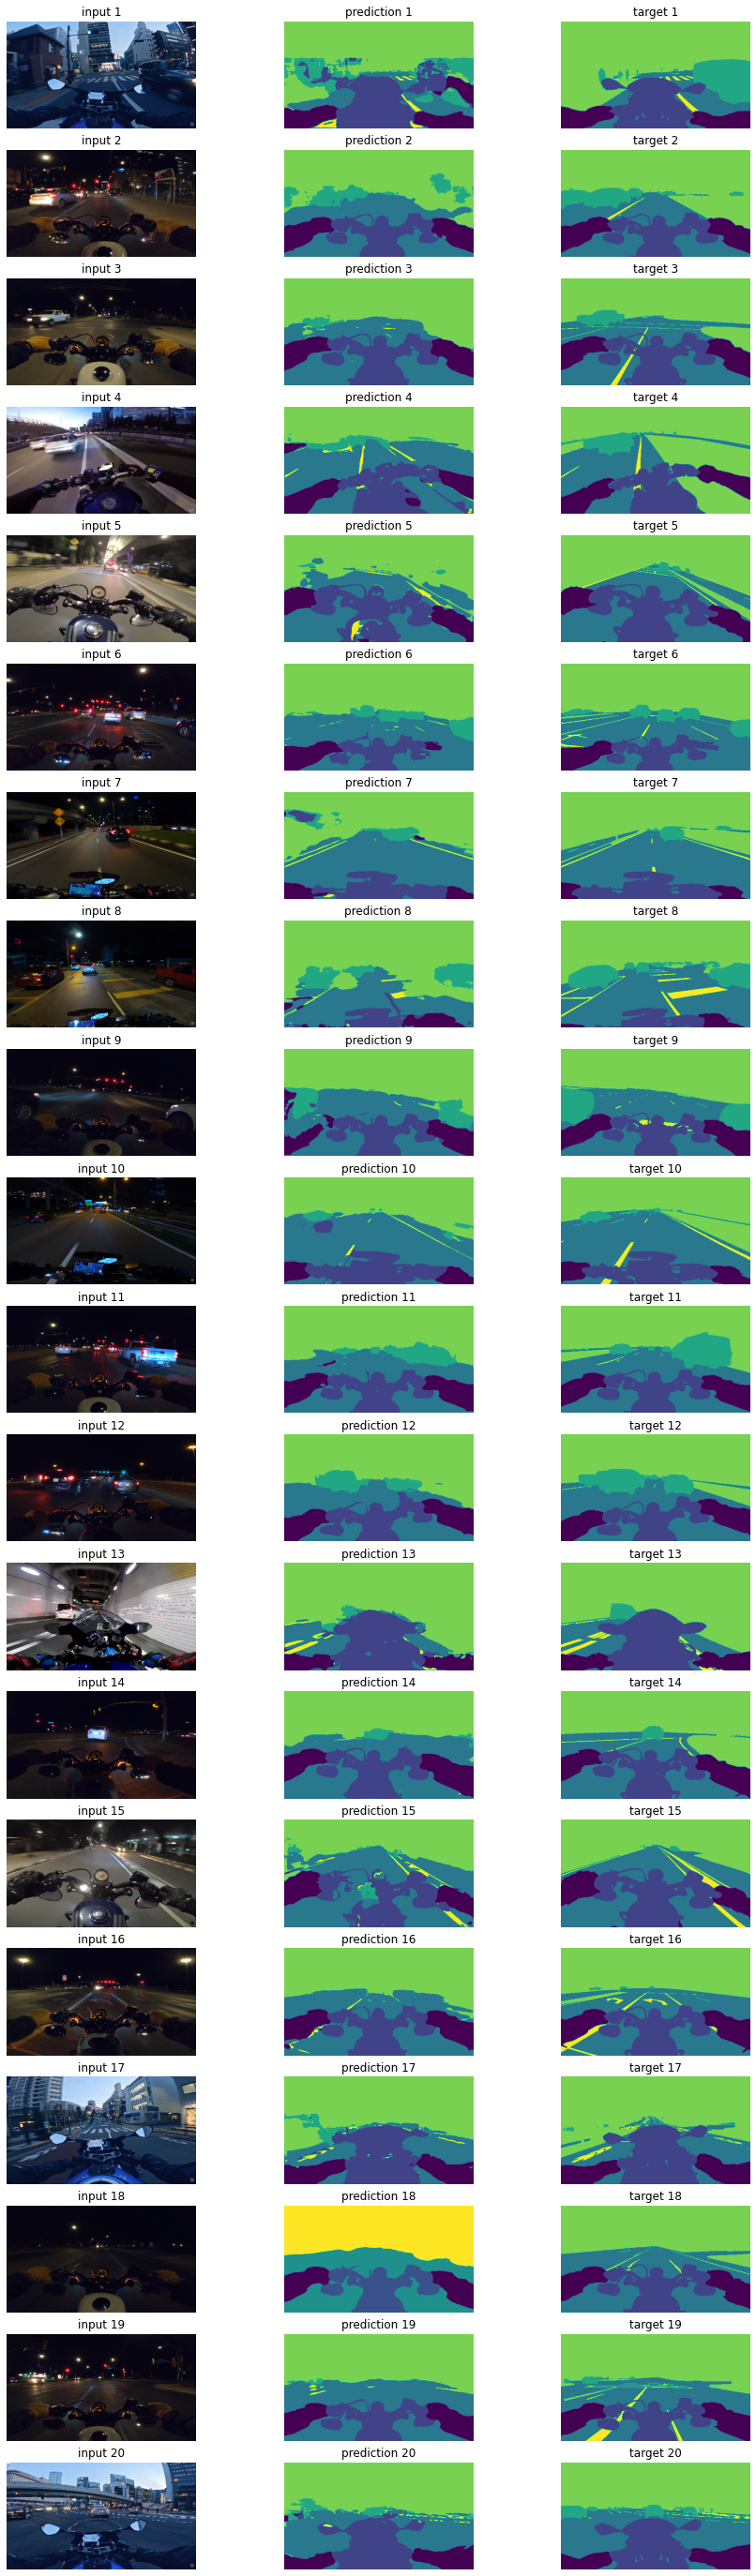

In [27]:
# 모델의 예측 결과 시각화

def convert_output(pred):
    out = np.argmax(pred, axis=-1)
    return out

plt.figure(figsize=(15,50))

for i in range(20):
    plt.subplot(20,3,3*i+1)
    plt.axis('off')
    plt.imshow(test_input_imgs[i]/255)
    plt.title(f'input {i+1}')
    
    plt.subplot(20,3,3*i+2)
    plt.axis('off')
    output = prediction[i]
    output_img = convert_output(output)
    plt.imshow(output_img)
    plt.title(f'prediction {i+1}')
    
    plt.subplot(20,3,3*i+3)
    plt.axis('off')
    plt.imshow(test_targets[i])
    plt.title(f'target {i+1}')

예측 결과와 실제 세그멘테이션이 비슷한 편이지만 디테일한 부분에서 약간의 차이가 발생한다. 특히 lanemark 영역을 잘 잡아내지 못하는 경우가 많다. 18번 샘플의 경우 배경을 lanemark로 예측하는 오류가 발생했다. 탑승 중인 오토바이와 운전자의 경우 대체로 잘 구분하고 있다.

160개의 적은 학습 데이터임을 감안하면 비교적 괜찮은 성능의 모델이라고 생각된다. 데이터 증강을 통해 더 개선될 수 있는지 확인해보자.

## 모델 개선 - 데이터 증강

In [28]:
# 모델 정의 - 데이터 증강 층 추가

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

def get_model(img_size, num_classes):

    inputs = Input(shape=img_size + (3,))
    rs = Rescaling(1./255)(inputs)
    
    aug = RandomFlip("horizontal")(rs)
    aug = RandomRotation(0.1)(aug)
    aug = RandomZoom(0.2)(aug)
    
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(aug)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(c9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = get_model(img_size=img_size, num_classes=6)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 272, 480, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 272, 480, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 272, 480, 3)  0           rescaling_1[0][0]                
__________________________________________________________________________________________________
random_rotation (RandomRotation (None, 272, 480, 3)  0           random_flip[0][0]                
____________________________________________________________________________________________

In [29]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [TensorBoard(log_dir='./log_aug'), ModelCheckpoint("segmentation_aug.h5", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets, 
                    epochs=100, 
                    callbacks=callbacks, 
                    batch_size=16, 
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/100
10/10 [==============================] - 20s 2s/step - loss: 6.1700 - accuracy: 0.3011 - val_loss: 1.6207 - val_accuracy: 0.2377
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 1.5148 - accuracy: 0.3675 - val_loss: 1.4421 - val_accuracy: 0.4441
Epoch 3/100
10/10 [==============================] - 17s 2s/step - loss: 1.4312 - accuracy: 0.4222 - val_loss: 1.4260 - val_accuracy: 0.4453
Epoch 4/100
10/10 [==============================] - 17s 2s/step - loss: 1.4105 - accuracy: 0.4231 - val_loss: 1.4098 - val_accuracy: 0.4453
Epoch 5/100
10/10 [==============================] - 17s 2s/step - loss: 1.3933 - accuracy: 0.4234 - val_loss: 1.3871 - val_accuracy: 0.4462
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 1.3915 - accuracy: 0.4263 - val_loss: 1.3819 - val_accuracy: 0.4413
Epoch 7/100
10/10 [==============================] - 17s 2s/step - loss: 1.3910 - accuracy: 0.4387 - val_loss: 1.3902 - val_accuracy: 0.4482
Epoch 8/100
1

Epoch 59/100
10/10 [==============================] - 17s 2s/step - loss: 0.8143 - accuracy: 0.6681 - val_loss: 0.7953 - val_accuracy: 0.7131
Epoch 60/100
10/10 [==============================] - 17s 2s/step - loss: 0.8057 - accuracy: 0.6723 - val_loss: 0.7618 - val_accuracy: 0.7094
Epoch 61/100
10/10 [==============================] - 17s 2s/step - loss: 0.7962 - accuracy: 0.6759 - val_loss: 0.7422 - val_accuracy: 0.7319
Epoch 62/100
10/10 [==============================] - 17s 2s/step - loss: 0.7816 - accuracy: 0.6836 - val_loss: 0.7501 - val_accuracy: 0.7236
Epoch 63/100
10/10 [==============================] - 17s 2s/step - loss: 0.7866 - accuracy: 0.6798 - val_loss: 0.7401 - val_accuracy: 0.7247
Epoch 64/100
10/10 [==============================] - 17s 2s/step - loss: 0.7863 - accuracy: 0.6809 - val_loss: 0.7515 - val_accuracy: 0.7077
Epoch 65/100
10/10 [==============================] - 17s 2s/step - loss: 0.7825 - accuracy: 0.6825 - val_loss: 0.7758 - val_accuracy: 0.7007
Epoch 

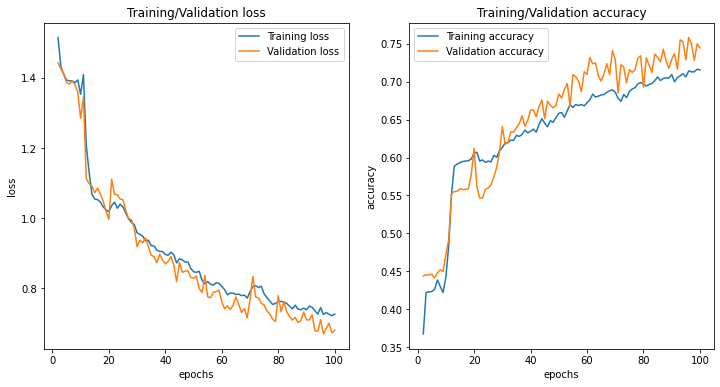

In [30]:
# 결과 시각화

epochs = range(1, len(history.history["loss"]) + 1)[1:]
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
acc = history.history["accuracy"][1:]
val_acc = history.history["val_accuracy"][1:]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy")
plt.legend()

학습이 좀 더 진행되어야 할 것으로 보인다.

In [31]:
history = model.fit(train_input_imgs, train_targets, 
                    epochs=50, 
                    callbacks=callbacks, 
                    batch_size=16, 
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
10/10 [==============================] - 17s 2s/step - loss: 0.7169 - accuracy: 0.7185 - val_loss: 0.6680 - val_accuracy: 0.7610
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.7216 - accuracy: 0.7187 - val_loss: 0.7044 - val_accuracy: 0.7337
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 0.7376 - accuracy: 0.7120 - val_loss: 0.6619 - val_accuracy: 0.7576
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 0.7134 - accuracy: 0.7208 - val_loss: 0.6608 - val_accuracy: 0.7519
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 0.7161 - accuracy: 0.7184 - val_loss: 0.6808 - val_accuracy: 0.7459
Epoch 6/50
10/10 [==============================] - 17s 2s/step - loss: 0.7096 - accuracy: 0.7213 - val_loss: 0.6854 - val_accuracy: 0.7442
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 0.7194 - accuracy: 0.7210 - val_loss: 0.6802 - val_accuracy: 0.7488
Epoch 8/50
10/10 [==

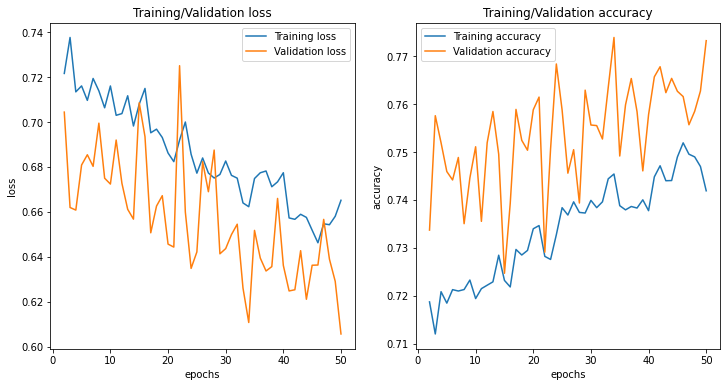

In [32]:
# 결과 시각화

epochs = range(1, len(history.history["loss"]) + 1)[1:]
loss = history.history["loss"][1:]
val_loss = history.history["val_loss"][1:]
acc = history.history["accuracy"][1:]
val_acc = history.history["val_accuracy"][1:]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training/Validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training/Validation accuracy")
plt.legend()

여전히 기존 모델에 못 미치는 성능을 보이고 있다. 학습을 진행하던 도중 원인을 파악했는데, 모델 내부에서 입력 데이터를 랜덤하게 변형하는 방식으로 데이터 증강을 구현하면 입력 데이터만 변형되고 타겟 데이터는 그대로이기 때문에 입력과 타겟의 대응 관계가 깨진다. 따라서 학습이 잘 진행될 수 없을 것이다. 이 점을 고려하여 다른 방식으로 데이터 증강을 구현해야 한다(ㅠㅠ).